<a href="https://colab.research.google.com/github/Aras1703/LSTM-Electrical_Consume_Prediction/blob/main/Time_Series_Analysis_Electricity_Consume_Predicting_using_LSTM_(Tensorflow).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Library**

In [ ]:
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from datetime import datetime
import requests
import tensorflow as tf
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#**Import Data**

In [ ]:
df = pd.read_csv('opsd_germany_daily.csv')
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,1/1/2006,1069.18400,NaN,NaN,NaN
1,1/2/2006,1380.52100,NaN,NaN,NaN
2,1/3/2006,1442.53300,NaN,NaN,NaN
3,1/4/2006,1457.21700,NaN,NaN,NaN
4,1/5/2006,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,12/27/2017,1263.94091,394.507,16.530,411.037
4379,12/28/2017,1299.86398,506.424,14.162,520.586
4380,12/29/2017,1295.08753,584.277,29.854,614.131
4381,12/30/2017,1215.44897,721.247,7.467,728.714


#**Feature Selection**

In [ ]:
df = df[['Date', 'Consumption']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df['Date'],inplace=True)
df.drop(columns='Date', axis=1, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Consumption
Date,
2006-01-01,1069.18400
2006-01-02,1380.52100
2006-01-03,1442.53300
2006-01-04,1457.21700
2006-01-05,1477.13100
...,...
2017-12-27,1263.94091
2017-12-28,1299.86398
2017-12-29,1295.08753


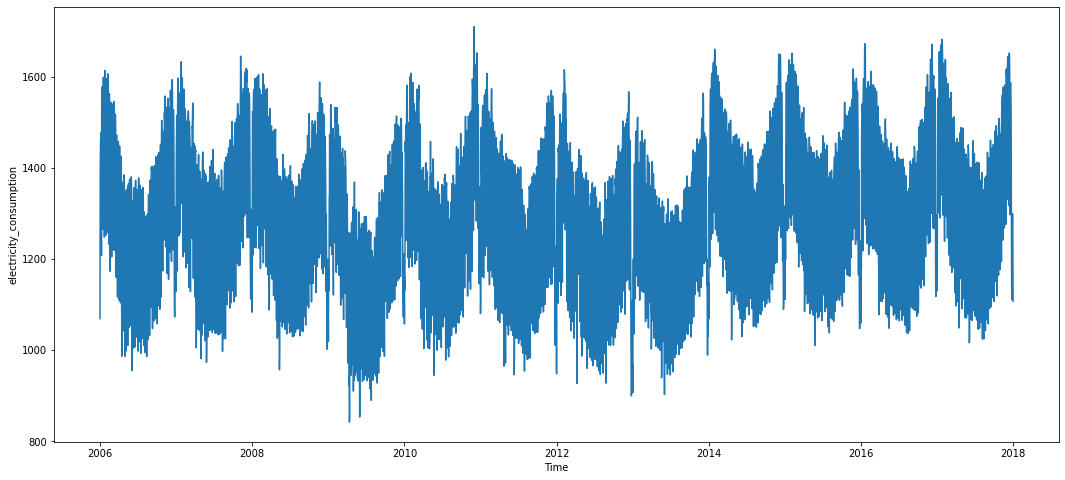

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(df['Consumption'])
plt.xlabel('Time')
plt.ylabel('electricity_consumption')
plt.grid(False)
plt.show()

#**Preprocessing & Dataset Splitting**

In [ ]:
#df = df.values
#df

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data

array([[-1.62582675],
       [ 0.25244916],
       [ 0.62656353],
       ...,
       [-0.26296542],
       [-0.74341968],
       [-1.39699221]])

#**Train Split Function**

In [ ]:
def train_split(dataframe, split):
  data_array = dataframe
  training_len = int(np.ceil(len(data_array)*split))
  scaled_data = data_array

  train_data = scaled_data[0:int(training_len), :]
  X_train = []
  y_train = []
  for i in range(24, len(train_data)):
      X_train.append(train_data[i-24:i, 0])
      y_train.append(train_data[i, 0])
  
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  return X_train, y_train, training_len, scaled_data, data_array

In [ ]:
X_train_70, y_train_70, training_len_70, scaled_data, data_array = train_split(dataframe=scaled_data, split=.70)

#**Architecture Model**

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, return_sequences=False, input_shape = (X_train_70.shape[1], 1)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(X_train_70, y_train_70, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


96/96 [==============================] - 4s 10ms/step - loss: 0.4638 - mae: 0.8332 - lr: 1.0000e-06
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4636 - mae: 0.8330 - lr: 1.1220e-06
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4635 - mae: 0.8329 - lr: 1.2589e-06
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.4633 - mae: 0.8328 - lr: 1.4125e-06
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4631 - mae: 0.8326 - lr: 1.5849e-06
Epoch 6/100
96/96 [==============================] - 1s 11ms/step - loss: 0.4629 - mae: 0.8324 - lr: 1.7783e-06
Epoch 7/100
96/96 [==============================] - 1s 11ms/step - loss: 0.4627 - mae: 0.8322 - lr: 1.9953e-06
Epoch 8/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4624 - mae: 0.8319 - lr: 2.2387e-06
Epoch 9/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4622 - mae: 0.8317 - lr: 2.5119e-06
Epoc

#**Testing Dataset**

In [ ]:
scaled_data_test = scaler.transform(df)
scaled_data_test

array([[-1.62582675],
       [ 0.25244916],
       [ 0.62656353],
       ...,
       [-0.26296542],
       [-0.74341968],
       [-1.39699221]])

In [ ]:
def test_split(training_len, scaled_data_test):
  scaled_test = scaled_data_test
  test_data = scaled_test[training_len - 24:, :]

  X_test = []
  y_test = data_array[training_len:, :]
  for i in range(24, len(test_data)):
    X_test.append(test_data[i-24:i, 0])

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  return X_test, y_test, test_data

In [ ]:
X_test_30, y_test_30, test_data_30 = test_split(training_len_70, scaled_data_test)

#**Model Predicting**

In [ ]:
def predict(X_test, model):
  predictions = model.predict(X_test)
  predictions
  
  return predictions

In [ ]:
predictions_30 = predict(X_test_30, model)
predictions_30

array([[ 0.77203095],
       [ 0.5587388 ],
       [-1.0101944 ],
       ...,
       [-0.32357076],
       [-0.8884374 ],
       [-1.7721416 ]], dtype=float32)

In [ ]:
predictions_inverse_30 = scaler.inverse_transform(predictions_30)
predictions_inverse_30

array([[1466.6453],
       [1431.2906],
       [1171.2292],
       ...,
       [1285.0417],
       [1191.4113],
       [1044.9313]], dtype=float32)

#**Model Evaluate**

In [ ]:
var=explained_variance_score(y_test_30, predictions_30) 
mae=mean_absolute_error(y_test_30, predictions_30)
mse=mean_squared_error (y_test_30, predictions_30)
rmse=np.sqrt(mse)
r2=r2_score(y_test_30, predictions_30)  
metric=[var,mae,mse,rmse,r2]
evaluate=['Explained variance','MAE','MSE','RMSE','R^2']
performance_evaluate=pd.DataFrame([evaluate,metric])
performance_evaluate

,0,1,2,3,4
0,Explained variance,MAE,MSE,RMSE,R^2
1,0.877394,0.198987,0.116328,0.341069,0.876158


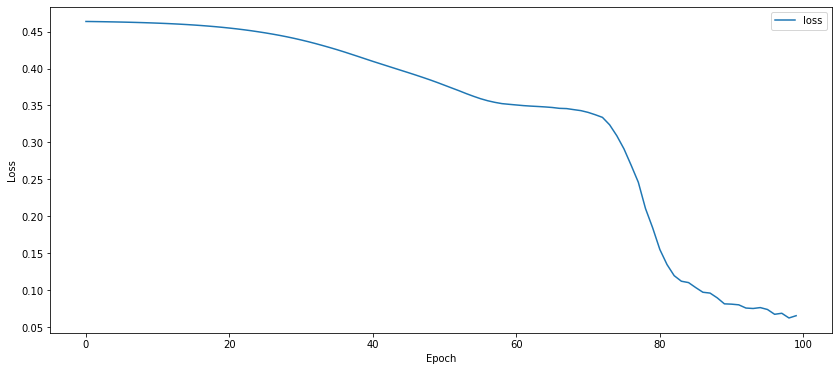

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(history.history["loss"], label="loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#**Transform Ndarray to Dataframe**

In [ ]:
def compare(dataframe, training_len, predictions):
  train = df[:training_len]
  valid = df[training_len:]
  valid['Predictions'] = predictions
  
  return train, valid

In [ ]:
train_70, valid_30 = compare(df, training_len_70, predictions_inverse_30)
valid_30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Consumption,Predictions
Date,,
2014-05-28,1441.62200,1466.645264
2014-05-29,1128.15100,1431.290649
2014-05-30,1261.20800,1171.229248
2014-05-31,1147.44000,1168.397583
2014-06-01,1068.98200,1083.912476
...,...,...
2017-12-27,1263.94091,1193.658691
2017-12-28,1299.86398,1267.843750
2017-12-29,1295.08753,1285.041748


In [ ]:
valid_30.tail()

,Consumption,Predictions
Date,,
2017-12-27,1263.94091,1193.658691
2017-12-28,1299.86398,1267.843750
2017-12-29,1295.08753,1285.041748
2017-12-30,1215.44897,1191.411255
2017-12-31,1107.11488,1044.931274


In [ ]:
def plot_predict(train, valid):
  plot = plt.figure(figsize=(17, 7))
  plot = plt.plot(train['Consumption'], label = "Traning", c = "b")
  plot = plt.plot(valid['Consumption'], label = "Validation", c = "g")
  plot = plt.plot(valid['Predictions'], label = "Predict", c = "r")
  plot = plt.legend()
  plot = plt.show()

  return plot

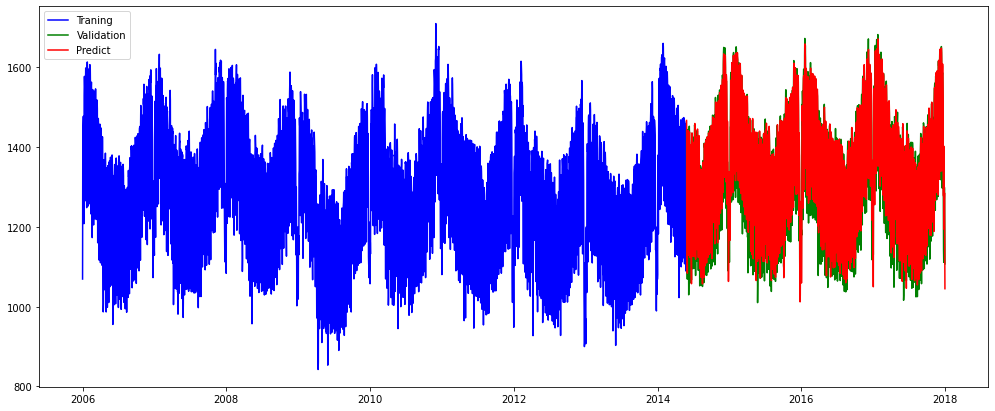

In [ ]:
plot_predict_70_30 = plot_predict(train_70, valid_30)
plot_predict_70_30